# LIBRERIAS A USAR

## Instalamos las dependecias necesarias

In [250]:
# !pip3 install --upgrade wandb
#!pip install scikit-learn

## Importamos las librerias y sus submodulos

In [251]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import sklearn
import os
import time

In [252]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from keras import layers
from keras import initializers
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping

## Definimos los híper-parámetros

In [253]:
lr = 0.005 #Learning rate
epochs = 50
bs = 120 #batch size
loss = "mse"
optimizer = "ADAM"
regularizer = "L2"

In [254]:
# run = wandb.init(
#     settings=wandb.Settings(x_disable_stats=False, x_stats_sampling_interval = 1.0),
#     # set the wandb project where this run will be logged
#     name = "Intento_intento_con_DO_L1L2_adam_more_data",
#     project = "Creacion_de_regresion_lineal",
#     group = "Pol",

#     # track hyperparameters and run metadata with wandb.config
#     config = {
#         "layer_1": 512,
#         "activation": "relu",
#         "w_initializer": "He Initialization",
#         "optimizer": optimizer,
#         "loss": loss,
#         "metric": "mse",
#         "epoch": epochs,
#         "batch_size": bs,
#         "layer_quantity": 1,
#         "regularizer": regularizer,
#         "Modelo": "Pol"
#     }
# )
# time.sleep(3.0)

# Antes de empezar

## Creamos el nuevo layer polinomial

In [255]:
class PolynomialTransform(tf.keras.layers.Layer):
    def __init__(self, degree):
        super(PolynomialTransform,self).__init__()
        
        self.num_outputs = degree + 1 #Se define la cantidad de potencias con las que se trabajara (incluido el 0)
        self.powers =  tf.range(start = 0.0, limit = self.num_outputs) #Se crea el array de potencias 
        self.kernel = self.add_weight(name = "kernel", shape=[self.num_outputs]) #Se crea el array de pesos

    def poly_terms(self, inputs):
        #Garantizamos que se aplique a cualquier dato, array o no
        inputs = tf.convert_to_tensor(inputs)
        if (inputs.shape == ()):
            inputs=(inputs,)
        elif (len(inputs.shape)==1):
            inputs=tf.expand_dims(inputs, axis=1)
       
        #Sacamos la longitud del batch para conseguir la matriz de potencias
        batch = tf.shape(inputs)[0]

        #Expandimos los array de entrada y de potencias para que sean compatibles
        inputs_expanded = tf.expand_dims(inputs, axis=-1)  #[batch, 1, 1]
        powers_expanded = tf.expand_dims(self.powers, axis=0)  #[1, num_outputs]
        powers_expanded = tf.expand_dims(powers_expanded, axis=0)  #[1, 1, num_outputs]
    
        poly_terms = tf.math.pow(inputs_expanded, powers_expanded)  #[batch, 1, num_outputs]
        poly_terms = tf.squeeze(poly_terms, axis=1)  #[batch, num_outputs]
        return poly_terms

    def polynomial(self, inputs, coefficients):
        terms = self.poly_terms(inputs)
        coefficients = tf.convert_to_tensor(coefficients, dtype=tf.float32)
        coefficients = tf.reshape(coefficients, [self.num_outputs])  
        return tf.tensordot(terms, coefficients, 1) #[batch] --> batch_i = a_i*(x**i)
    
    def call(self, inputs):
        terms = self.poly_terms(inputs)
        terms = tf.tensordot(terms, self.kernel, 1) #[batch] --> batch_i = a_i*(x**i)
        return tf.expand_dims(terms, axis = -1)

### Verificamos su funcionalidad

In [256]:
# prueba1 = PolynomialTransform(degree = 3) #Definimos un polinomio de grado 3
# delta = 0.01
# x1 = tf.range(-4,4,delta = delta) #Arreglo 1D
# print(tf.shape(x1))
# res1 = prueba1(inputs = x)
# plt.scatter(x,res1)

In [257]:
# prueba2 = PolynomialTransform(degree = 5)
# x2 = tf.reshape(x1, [800,1])  # Arreglo 2D
# print(tf.shape(x2))
# res2 = prueba2(inputs = x2)
# plt.scatter(x2,res2)

## Creamos y preparamos los datos de entrenamiento

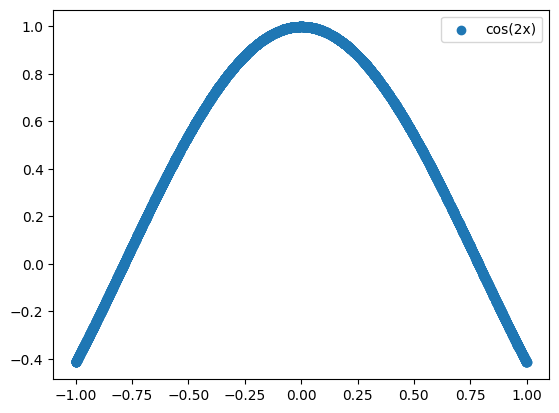

In [258]:
batch_size = 5000
Polynomial = PolynomialTransform(3)
x = tf.random.uniform((batch_size,), minval=-1, maxval=1)
y = tf.math.cos(2*x)
plt.scatter(x,y, label = "cos(2x)")
plt.legend()

In [259]:
domain = tf.reshape(x,[-1,1])
codomain_cos = tf.reshape(y,[-1,1])
domain = domain.numpy()
codomain_cos = codomain_cos.numpy()
X_train, X_test, y_train, y_test = train_test_split(domain, codomain_cos, test_size=0.2, random_state=42)

In [260]:
scale_x = StandardScaler()
scale_y = StandardScaler()
X_train, y_train = scale_x.fit_transform(X_train), scale_y.fit_transform(y_train)
X_test, y_test = scale_x.transform(X_test), scale_y.transform(y_test)

# Creamos la red neuronal

### Usamos functional API

In [275]:
n = 3
inputs = keras.Input(shape=(1,))
poly_out = PolynomialTransform(degree = n)(inputs)
# dense_out = Dense(10, activation='relu', name = "Layer2")(poly_out)
dense_out = Dense(5, activation='tanh', name = "Layer3")(poly_out)
final_out = Dense(1, name = "Layer4")(dense_out)

In [276]:
model = keras.Model(inputs = inputs, outputs = final_out)
model.build(input_shape = inputs)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_44 (InputLayer)     │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ polynomial_transform_63         │ (None, 1)              │             4 │
│ (PolynomialTransform)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Layer3 (Dense)                  │ (None, 5)              │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Layer4 (Dense)                  │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20 (80.00 B)

 Trainable params: 20 (80.00 B)

 Non-trainable params: 0 (0.00 B)

In [277]:
# for layer in model.layers:
#    if hasattr(layer, 'kernel_initializer'):
#        new_weights = layer.kernel_initializer(layer.kernel.shape)
#        layer.kernel.assign(new_weights)
#    if hasattr(layer, 'bias_initializer') and layer.bias is not None:
#        new_bias = layer.bias_initializer(layer.bias.shape)
#        layer.bias.assign(new_bias)

### Entrenamos la red

In [278]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
verbose = 1

history = model.fit(X_train, y_train,
                    batch_size = bs,
                    epochs = epochs,
                    verbose = verbose,
                    validation_data = (X_test, y_test),
                    # callbacks=[
                    #     WandbMetricsLogger(log_freq=1),
                    #     WandbModelCheckpoint("models/model.keras")
                    # ]
                            )
# run.finish()

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.9115 - val_loss: 0.8305
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8443 - val_loss: 0.7646
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7689 - val_loss: 0.6741
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6478 - val_loss: 0.5308
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4787 - val_loss: 0.3662
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3130 - val_loss: 0.2301
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1900 - val_loss: 0.1371
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1124 - val_loss: 0.0844
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0703 - val_loss: 0.0571
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0493 - val_loss: 0.0438
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0391 - val_loss: 0.0372
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0339 - val_lo

# Evaluación de la red neuronal

## Evaluamos la red en el dominio [-1,1]

In [279]:
x_validation = np.linspace(-1,1, 1000).reshape(-1,1)
prediction = model.predict(x_validation)
prediction = scale_y.inverse_transform(prediction)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


## Comparamos la predicción con el modelo real

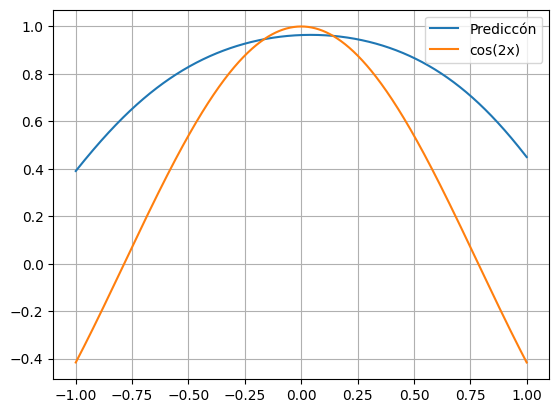

In [280]:
plt.plot(x_validation, prediction, label = "Prediccón")
plt.plot(x_validation, np.cos(2*x_validation), label = "cos(2x)")
plt.legend()
plt.grid()
plt.show()